In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [3]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [4]:
def join_data(observed, estimated, labels):
    #Remove hour and minute values
    observed = observed.assign(date_forecast=observed.date_forecast.dt.round('H'))
    estimated = estimated.assign(date_forecast=estimated.date_forecast.dt.round('H'))
    
    #rename columns names to match
    observed = observed.rename(columns={'date_forecast': 'date'})
    estimated = estimated.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    data = pd.concat([observed, estimated])
    joined_data = pd.merge(data, labels, how="inner", on="date")
    
    return joined_data
    

In [5]:
def remove_unused_columns(df):
    df = df.drop(['snow_drift:idx', 'elevation:m'], axis=1)
    return df


In [6]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [7]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df['date'], format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [8]:
def feature_date(df):
    df["month"] = [df["date"][i].month for i in range(len(df))]
    df["hour"] = [df["date"][i].hour for i in range(len(df))]
    df.pop('date')


In [9]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [10]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos", "month", "Hour", "pv_measurement"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [11]:
def combine_features(df, features, new_name):
    
    totals = []
    
    for i in range(len(df)):
        total = 0
        for feature in features:
            total += df[feature][i]
        
        totals.append(total)
            
   
    #df.drop(features, axis=1, inplace=True)
    df[new_name] = totals
    df[new_name] = df[new_name] #/ df[new_name].max()

In [12]:
def split_data(df):
    val_split = 0.2
   
    len_df = len(df)
    train_len = int(len_df * (1.0 - val_split))

    train = df.iloc[:train_len,:]
    val = df.iloc[train_len:,:]
    
    
    train = train.reset_index()
    train = train.drop(['index'], axis=1)
    
    val = val.reset_index()
    val = val.drop(['index'], axis=1)
    
    return train, val

In [13]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [14]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [15]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [16]:
data_a = join_data(X_train_observed_a, X_train_estimated_a, train_a)
data_b = join_data(X_train_observed_b, X_train_estimated_b, train_b)
data_c = join_data(X_train_observed_c, X_train_estimated_c, train_c)

In [17]:
# Fill 0 for NaNs
data_a = data_a.fillna(0)
test_a = test_a.fillna(0)

data_b = data_b.fillna(0)
test_b = test_b.fillna(0)

data_c = data_c.fillna(0)
test_c = test_c.fillna(0)

In [18]:
class Window:
    def __init__(self, targets, window_size=100):
        self.targets = targets
        self.window_size = window_size
        
        self.start = 0
        self.end = self.window_size
        
        
    def get(self):
        return self.targets[self.start: self.end]
    
    def next(self):
        self.start += 1
        self.end += 1
        
    def hasNext(self):
        if self.end < len(self.targets):
            return True
        
        return False
        
        

def find_constants(df):
    WINDOW_SIZE = 24
    
    window = Window(df["pv_measurement"], WINDOW_SIZE)
    
    constants = []
    
    while window.hasNext():
        if window.get().std() <= 0.1:
            constants.append((window.start, window.end))
        window.next()
            
    def extract_indices(ranges):
        return [start for start, _ in ranges]


    indices = extract_indices(constants)
    
    
    df = df.drop(indices)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    
    return df
    
    
    

In [19]:
data_a = find_constants(data_a)
data_b = find_constants(data_b)
data_c = find_constants(data_c)

In [20]:
#Convert date into sin and cos components
convert_date_to_sin_and_cos(data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(data_c)
convert_date_to_sin_and_cos(test_c)

In [21]:
# Isday should be a binary value
round_is_day(data_a)
round_is_day(test_a)

round_is_day(data_b)
round_is_day(test_b)

round_is_day(data_c)
round_is_day(test_c)

In [22]:
#normalize_except_columns(train_data_a)
#normalize_except_columns(val_data_a)
#normalize_except_columns(test_a)

#normalize_except_columns(train_data_b)
#normalize_except_columns(val_data_b)
#normalize_except_columns(test_b)

#normalize_except_columns(train_data_c)
#normalize_except_columns(val_data_c)
#normalize_except_columns(test_c)

In [23]:
combine_features(data_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_a, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_a, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(data_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_b, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_b, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')


combine_features(data_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')
combine_features(test_c, ['direct_rad:W', 'diffuse_rad:W'], 'global_rad:W')

combine_features(data_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')
combine_features(test_c, ['direct_rad_1h:J', 'diffuse_rad_1h:J'], 'global_rad_1h:J')

In [24]:
# Fill 0 for NaNs
data_a = data_a.fillna(0)
test_a = test_a.fillna(0)

data_b = data_b.fillna(0)
test_b = test_b.fillna(0)

data_c = data_c.fillna(0)
test_c = test_c.fillna(0)

In [25]:
data_a = remove_unused_columns(data_a)
test_a = remove_unused_columns(test_a)

data_b = remove_unused_columns(data_b)
test_b = remove_unused_columns(test_b)

data_c = remove_unused_columns(data_c)
test_c = remove_unused_columns(test_c)

In [26]:
#data_a["pv_measurement"] = [math.log(data_a["pv_measurement"][i] +1) for i in range(len(data_a))]
#data_b["pv_measurement"] = [math.log(data_b["pv_measurement"][i] +1) for i in range(len(data_b))]
#data_c["pv_measurement"] = [math.log(data_c["pv_measurement"][i] +1) for i in range(len(data_c))]

<Axes: >

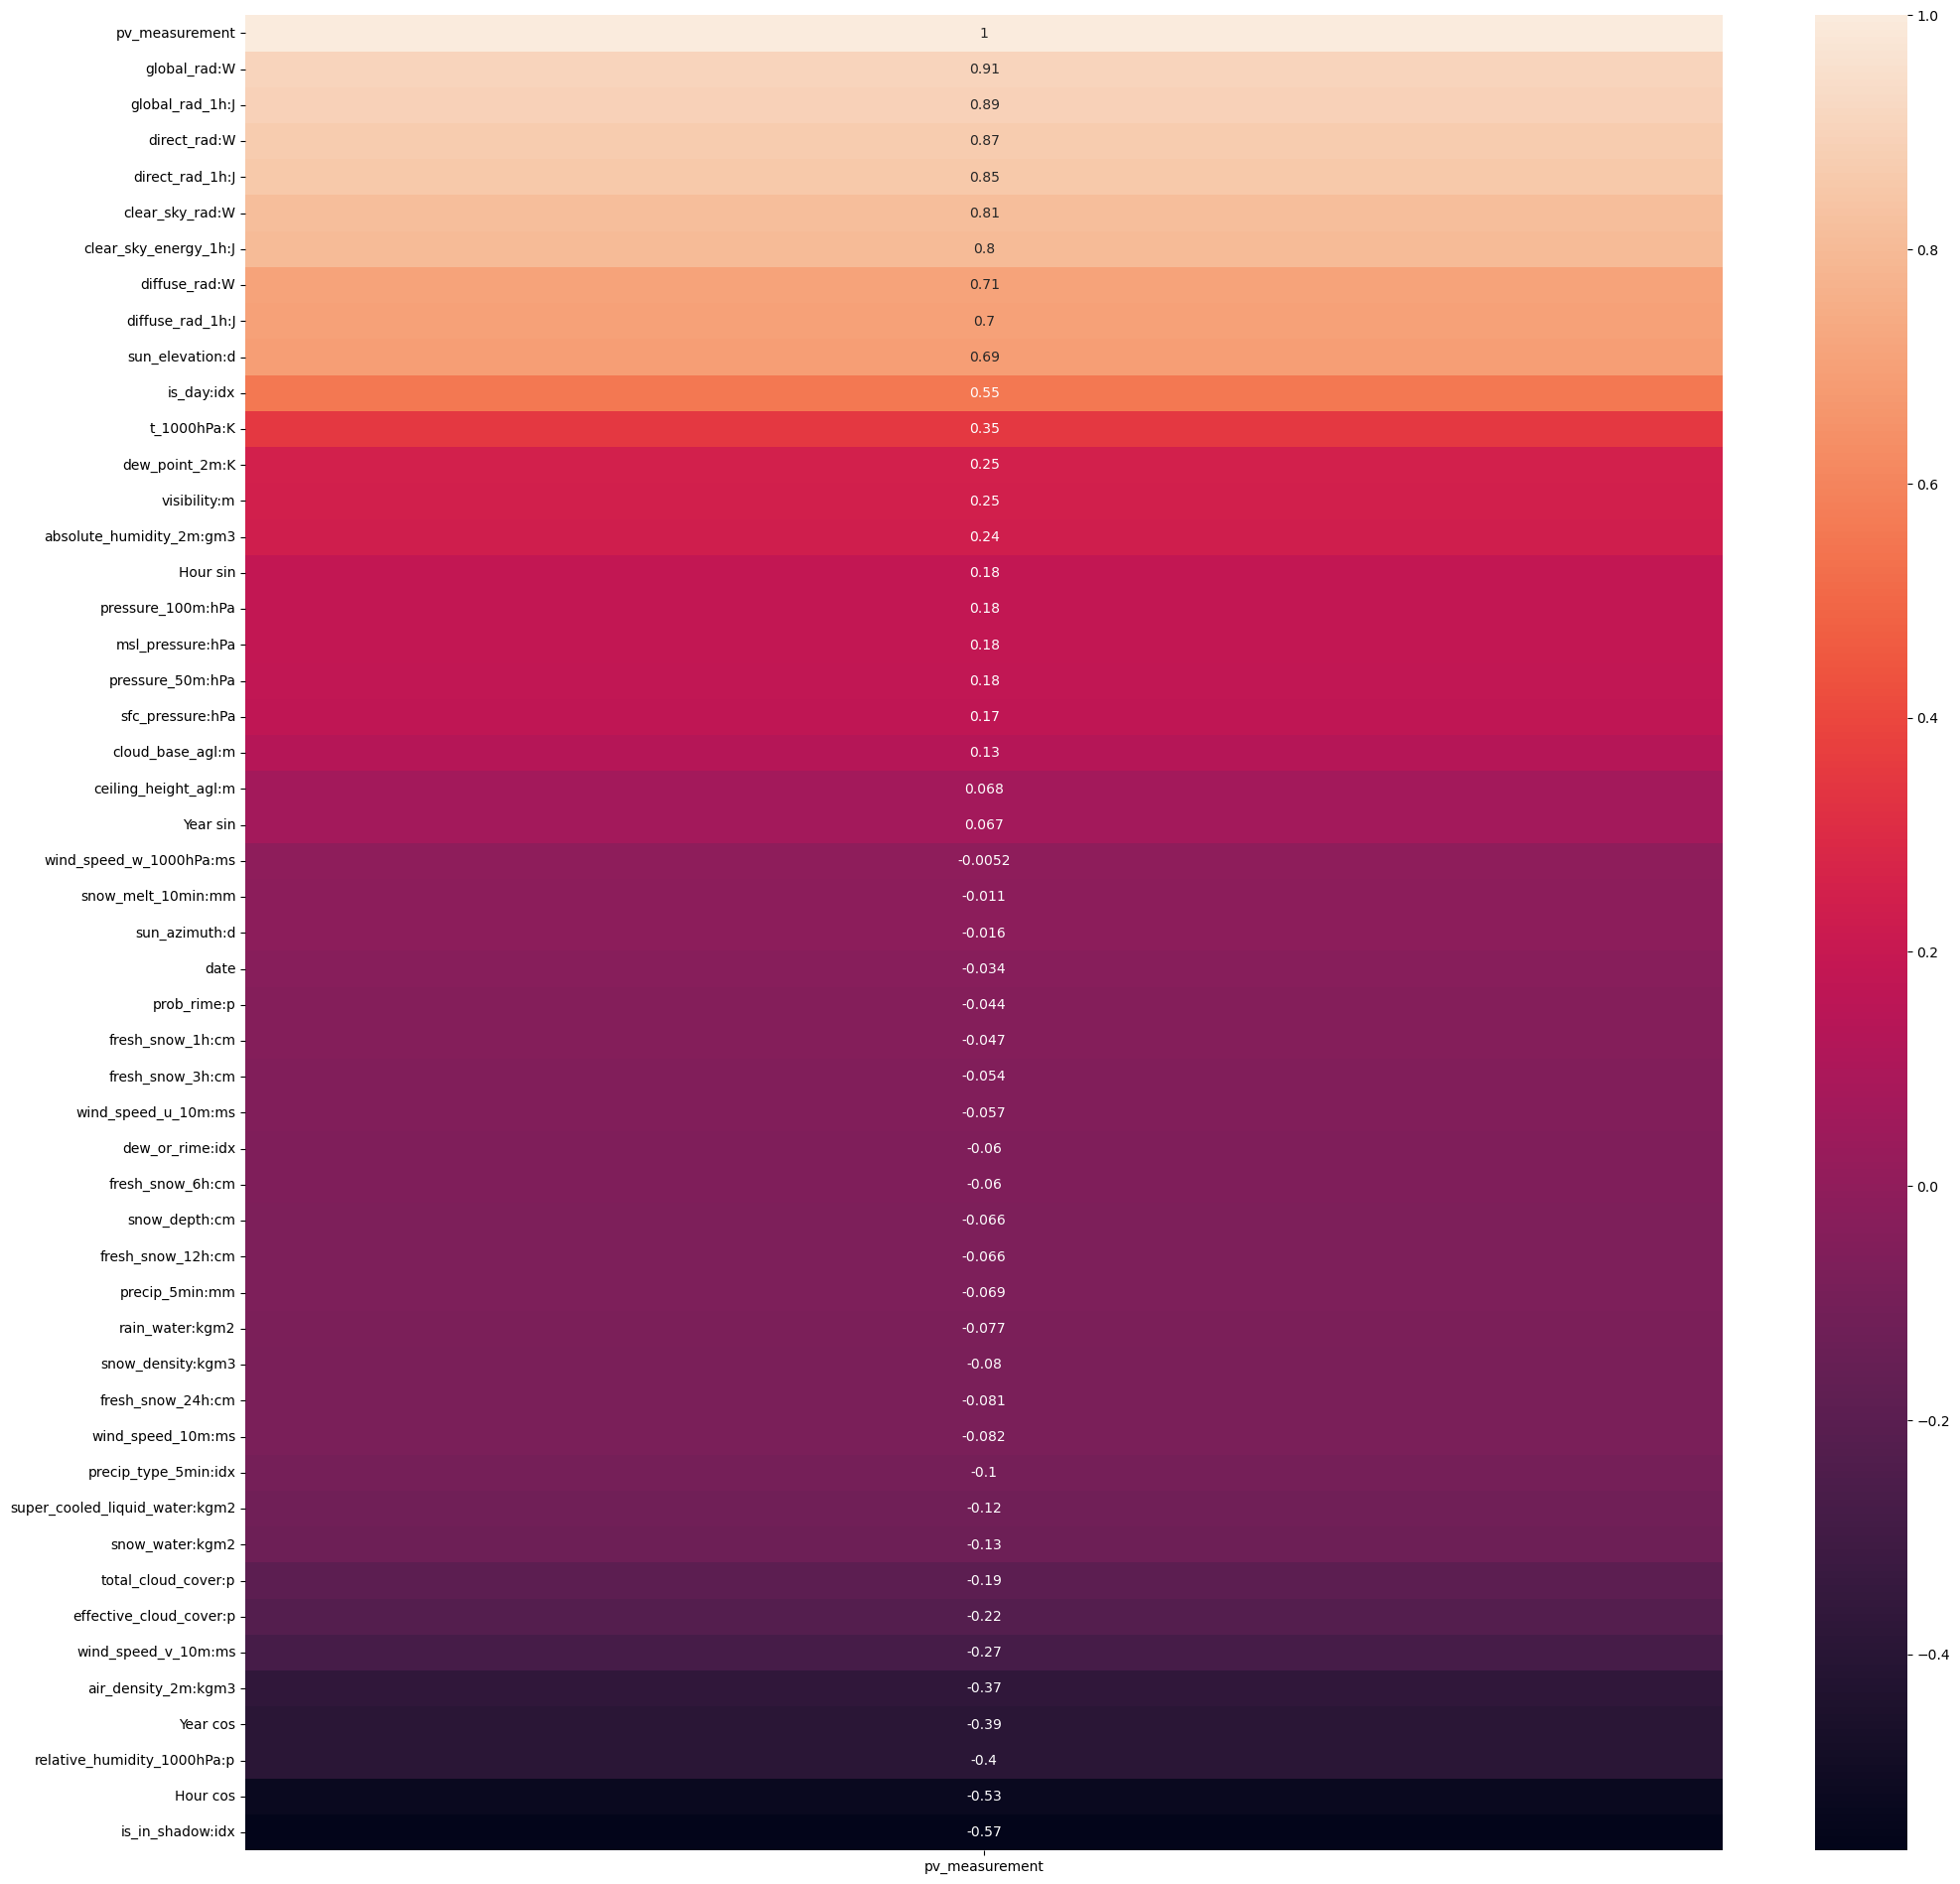

In [27]:
corr = data_a.corr()[['pv_measurement']].sort_values(by='pv_measurement', ascending=False)
plt.figure(figsize=(24, 24))

sns.heatmap(corr, annot=True)

In [28]:
train_data_a, val_data_a = split_data(data_a)
train_data_b, val_data_b = split_data(data_b)
train_data_c, val_data_c = split_data(data_c)

In [29]:
train_data_a.drop(["date"], axis=1, inplace=True)
val_data_a.drop(["date"], axis=1, inplace=True)
test_a.drop(["date"], axis=1, inplace=True)

train_data_b.drop(["date"], axis=1, inplace=True)
val_data_b.drop(["date"], axis=1, inplace=True)
test_b.drop(["date"], axis=1, inplace=True)


train_data_c.drop(["date"], axis=1, inplace=True)
val_data_c.drop(["date"], axis=1, inplace=True)
test_c.drop(["date"], axis=1, inplace=True)


In [30]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [31]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [32]:
import gc
gc.collect()

15

[15:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[15:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[15:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[15:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[15:53:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:631.78066+5.85950	test-mae:631.89910+23.47336
[1]	train-mae:601.21801+5.58832	test-mae:601.37907+22.29284
[2]	train-mae:572.30687+5.33917	test-mae:572.65849+21.31351
[3]	train-mae:544.82105+5.09209	test-mae:545.36631+20.34418
[4]	train-mae:518.82460+4.84972	test-mae:519.75318+19.37265


[126]	train-mae:61.66979+0.64755	test-mae:183.53652+3.32082
[127]	train-mae:61.43154+0.62919	test-mae:183.51658+3.29855
[128]	train-mae:61.25035+0.64102	test-mae:183.51254+3.29154
[129]	train-mae:61.07246+0.58388	test-mae:183.49519+3.28867
[130]	train-mae:60.86442+0.54675	test-mae:183.46444+3.29112
[131]	train-mae:60.55508+0.55229	test-mae:183.40724+3.26641
[132]	train-mae:60.32532+0.49709	test-mae:183.36701+3.29485
[133]	train-mae:60.20010+0.49551	test-mae:183.34346+3.30173
[134]	train-mae:59.99767+0.59986	test-mae:183.31508+3.26442
[135]	train-mae:59.79307+0.52624	test-mae:183.27447+3.26947
[136]	train-mae:59.57669+0.67586	test-mae:183.25088+3.25337
[137]	train-mae:59.39688+0.68467	test-mae:183.24129+3.27351
[138]	train-mae:59.19080+0.73768	test-mae:183.21176+3.24022
[139]	train-mae:58.92896+0.69168	test-mae:183.18860+3.24054
[140]	train-mae:58.73884+0.65502	test-mae:183.13804+3.26875
[141]	train-mae:58.46330+0.69165	test-mae:183.10523+3.28107
[142]	train-mae:58.22155+0.74469	test-ma

[263]	train-mae:36.99482+0.50156	test-mae:180.41789+3.49543
[264]	train-mae:36.81918+0.46036	test-mae:180.39141+3.50751
[265]	train-mae:36.70646+0.44367	test-mae:180.37915+3.53015
[266]	train-mae:36.54127+0.44821	test-mae:180.36312+3.52959
[267]	train-mae:36.37384+0.40167	test-mae:180.34450+3.53861
[268]	train-mae:36.22282+0.41220	test-mae:180.30767+3.53750
[269]	train-mae:36.12377+0.42579	test-mae:180.30049+3.53322
[270]	train-mae:35.96455+0.38463	test-mae:180.29072+3.54446
[271]	train-mae:35.77951+0.41180	test-mae:180.26374+3.55845
[272]	train-mae:35.67040+0.43824	test-mae:180.24659+3.55427
[273]	train-mae:35.57800+0.45005	test-mae:180.23784+3.55249
[274]	train-mae:35.39454+0.44638	test-mae:180.22460+3.54907
[275]	train-mae:35.25775+0.48456	test-mae:180.21119+3.54719
[276]	train-mae:35.12295+0.46402	test-mae:180.20301+3.55626
[277]	train-mae:34.97857+0.45195	test-mae:180.19457+3.56529
[278]	train-mae:34.84458+0.47122	test-mae:180.18314+3.56313
[279]	train-mae:34.68698+0.44626	test-ma

[400]	train-mae:21.88694+0.61538	test-mae:178.76515+3.59925
[401]	train-mae:21.81587+0.59339	test-mae:178.75379+3.59467
[402]	train-mae:21.73001+0.57787	test-mae:178.75054+3.59484
[403]	train-mae:21.67294+0.58526	test-mae:178.74897+3.59794
[404]	train-mae:21.59006+0.60786	test-mae:178.73347+3.59808
[405]	train-mae:21.51950+0.62243	test-mae:178.72590+3.59481
[406]	train-mae:21.44807+0.60379	test-mae:178.71415+3.60187
[407]	train-mae:21.36953+0.60510	test-mae:178.70993+3.60904
[408]	train-mae:21.30600+0.59611	test-mae:178.70728+3.60573
[409]	train-mae:21.21371+0.58947	test-mae:178.69662+3.60977
[410]	train-mae:21.13875+0.59454	test-mae:178.68578+3.60633
[411]	train-mae:21.09108+0.59012	test-mae:178.68371+3.60929
[412]	train-mae:21.00015+0.57039	test-mae:178.67646+3.60378
[413]	train-mae:20.92114+0.55773	test-mae:178.66932+3.59840
[414]	train-mae:20.85550+0.58012	test-mae:178.66335+3.59045
[415]	train-mae:20.77606+0.57621	test-mae:178.65625+3.58654
[416]	train-mae:20.70783+0.58382	test-ma

[537]	train-mae:13.20884+0.43676	test-mae:177.85678+3.57135
[538]	train-mae:13.15459+0.43784	test-mae:177.85528+3.57796
[539]	train-mae:13.10938+0.43911	test-mae:177.85165+3.57513
[540]	train-mae:13.07808+0.44448	test-mae:177.85013+3.57503
[541]	train-mae:13.01213+0.43847	test-mae:177.84517+3.57822
[542]	train-mae:12.97336+0.43672	test-mae:177.83653+3.57894
[543]	train-mae:12.92993+0.43727	test-mae:177.83592+3.58176
[544]	train-mae:12.87479+0.42540	test-mae:177.82950+3.58524
[545]	train-mae:12.83566+0.41913	test-mae:177.82167+3.58383
[546]	train-mae:12.78784+0.40883	test-mae:177.81828+3.57993
[547]	train-mae:12.74385+0.39975	test-mae:177.81309+3.57948
[548]	train-mae:12.70066+0.41169	test-mae:177.80557+3.58049
[549]	train-mae:12.64203+0.40461	test-mae:177.79998+3.57865
[550]	train-mae:12.60645+0.41557	test-mae:177.80254+3.58022
[551]	train-mae:12.56557+0.41304	test-mae:177.80016+3.57751
[552]	train-mae:12.52660+0.41775	test-mae:177.79597+3.57924
[553]	train-mae:12.47751+0.40298	test-ma

[675]	train-mae:8.28908+0.19874	test-mae:177.36412+3.55727
[676]	train-mae:8.26539+0.19668	test-mae:177.36173+3.55832
[677]	train-mae:8.23634+0.19728	test-mae:177.36052+3.55772
[678]	train-mae:8.21437+0.19710	test-mae:177.35843+3.55666
[679]	train-mae:8.18772+0.19430	test-mae:177.35565+3.55639
[680]	train-mae:8.16411+0.19521	test-mae:177.35236+3.55492
[681]	train-mae:8.13771+0.19350	test-mae:177.35026+3.55413
[682]	train-mae:8.11072+0.19583	test-mae:177.34926+3.55306
[683]	train-mae:8.08528+0.19599	test-mae:177.35007+3.55359
[684]	train-mae:8.06068+0.19647	test-mae:177.34682+3.55203
[685]	train-mae:8.03615+0.19689	test-mae:177.34540+3.55397
[686]	train-mae:8.01319+0.19286	test-mae:177.34349+3.55471
[687]	train-mae:7.98897+0.19231	test-mae:177.34095+3.55443
[688]	train-mae:7.96645+0.19489	test-mae:177.34016+3.55365
[689]	train-mae:7.94285+0.18987	test-mae:177.34042+3.55156
[690]	train-mae:7.91925+0.18883	test-mae:177.33627+3.55069
[691]	train-mae:7.89070+0.18631	test-mae:177.33026+3.551

[814]	train-mae:5.72054+0.11738	test-mae:177.12549+3.55461
[815]	train-mae:5.70763+0.11640	test-mae:177.12458+3.55618
[816]	train-mae:5.69273+0.11510	test-mae:177.12411+3.55666
[817]	train-mae:5.68023+0.11509	test-mae:177.12227+3.55679
[818]	train-mae:5.66793+0.11337	test-mae:177.12043+3.55710
[819]	train-mae:5.65789+0.11436	test-mae:177.11952+3.55688
[820]	train-mae:5.64386+0.11356	test-mae:177.11722+3.55711
[821]	train-mae:5.63261+0.11289	test-mae:177.11517+3.55700
[822]	train-mae:5.61991+0.11267	test-mae:177.11513+3.55720
[823]	train-mae:5.60719+0.11187	test-mae:177.11314+3.55631
[824]	train-mae:5.59388+0.11183	test-mae:177.11154+3.55589
[825]	train-mae:5.58165+0.11017	test-mae:177.10972+3.55577
[826]	train-mae:5.56905+0.11080	test-mae:177.10782+3.55536
[827]	train-mae:5.55549+0.11118	test-mae:177.10595+3.55607
[828]	train-mae:5.54365+0.11085	test-mae:177.10476+3.55598
[829]	train-mae:5.53220+0.10906	test-mae:177.10357+3.55575
[830]	train-mae:5.52034+0.10750	test-mae:177.10205+3.554

[953]	train-mae:4.39814+0.07405	test-mae:176.98677+3.56162
[954]	train-mae:4.39094+0.07416	test-mae:176.98583+3.56161
[955]	train-mae:4.38387+0.07419	test-mae:176.98459+3.56172
[956]	train-mae:4.37715+0.07366	test-mae:176.98462+3.56131
[957]	train-mae:4.37055+0.07368	test-mae:176.98449+3.56040
[958]	train-mae:4.36341+0.07365	test-mae:176.98344+3.55988
[959]	train-mae:4.35730+0.07344	test-mae:176.98257+3.55912
[960]	train-mae:4.35053+0.07289	test-mae:176.98194+3.55900
[961]	train-mae:4.34477+0.07242	test-mae:176.98125+3.55947
[962]	train-mae:4.33790+0.07236	test-mae:176.98045+3.55897
[963]	train-mae:4.33175+0.07202	test-mae:176.98106+3.55876
[964]	train-mae:4.32481+0.07202	test-mae:176.97960+3.55897
[965]	train-mae:4.31858+0.07167	test-mae:176.97889+3.55890
[966]	train-mae:4.31206+0.07174	test-mae:176.97867+3.55948
[967]	train-mae:4.30546+0.07154	test-mae:176.97785+3.55959
[968]	train-mae:4.29859+0.07128	test-mae:176.97652+3.56001
[969]	train-mae:4.29243+0.07148	test-mae:176.97554+3.559

[1091]	train-mae:3.67328+0.05576	test-mae:176.90967+3.56123
[1092]	train-mae:3.66959+0.05519	test-mae:176.90952+3.56125
[1093]	train-mae:3.66588+0.05539	test-mae:176.90863+3.56151
[1094]	train-mae:3.66260+0.05480	test-mae:176.90853+3.56176
[1095]	train-mae:3.65879+0.05495	test-mae:176.90782+3.56156
[1096]	train-mae:3.65529+0.05484	test-mae:176.90750+3.56147
[1097]	train-mae:3.65160+0.05504	test-mae:176.90687+3.56157
[1098]	train-mae:3.64798+0.05468	test-mae:176.90636+3.56145
[1099]	train-mae:3.64418+0.05494	test-mae:176.90634+3.56119
[1100]	train-mae:3.64007+0.05519	test-mae:176.90522+3.56067
[1101]	train-mae:3.63624+0.05501	test-mae:176.90494+3.56057
[1102]	train-mae:3.63264+0.05485	test-mae:176.90437+3.56045
[1103]	train-mae:3.62869+0.05485	test-mae:176.90386+3.56089
[1104]	train-mae:3.62469+0.05484	test-mae:176.90338+3.56071
[1105]	train-mae:3.62107+0.05427	test-mae:176.90294+3.56088
[1106]	train-mae:3.61695+0.05375	test-mae:176.90220+3.56063
[1107]	train-mae:3.61281+0.05290	test-ma

[1228]	train-mae:3.23722+0.04458	test-mae:176.85267+3.55694
[1229]	train-mae:3.23436+0.04455	test-mae:176.85269+3.55718
[1230]	train-mae:3.23187+0.04449	test-mae:176.85277+3.55736
[1231]	train-mae:3.22925+0.04430	test-mae:176.85251+3.55754
[1232]	train-mae:3.22669+0.04437	test-mae:176.85230+3.55747
[1233]	train-mae:3.22409+0.04441	test-mae:176.85169+3.55761
[1234]	train-mae:3.22146+0.04419	test-mae:176.85138+3.55742
[1235]	train-mae:3.21840+0.04388	test-mae:176.85090+3.55736
[1236]	train-mae:3.21565+0.04346	test-mae:176.85055+3.55744
[1237]	train-mae:3.21281+0.04352	test-mae:176.85031+3.55711
[1238]	train-mae:3.21050+0.04346	test-mae:176.85036+3.55688
[1239]	train-mae:3.20796+0.04324	test-mae:176.85010+3.55651
[1240]	train-mae:3.20577+0.04338	test-mae:176.84971+3.55645
[1241]	train-mae:3.20308+0.04340	test-mae:176.84952+3.55601
[1242]	train-mae:3.20077+0.04323	test-mae:176.84894+3.55583
[1243]	train-mae:3.19845+0.04314	test-mae:176.84883+3.55569
[1244]	train-mae:3.19579+0.04307	test-ma

[1365]	train-mae:2.94208+0.03683	test-mae:176.81747+3.55828
[1366]	train-mae:2.94047+0.03687	test-mae:176.81703+3.55823
[1367]	train-mae:2.93890+0.03688	test-mae:176.81699+3.55836
[1368]	train-mae:2.93724+0.03686	test-mae:176.81683+3.55856
[1369]	train-mae:2.93564+0.03690	test-mae:176.81665+3.55851
[1370]	train-mae:2.93388+0.03681	test-mae:176.81682+3.55872
[1371]	train-mae:2.93218+0.03697	test-mae:176.81632+3.55886
[1372]	train-mae:2.93029+0.03716	test-mae:176.81616+3.55867
[1373]	train-mae:2.92842+0.03700	test-mae:176.81614+3.55862
[1374]	train-mae:2.92689+0.03720	test-mae:176.81608+3.55846
[1375]	train-mae:2.92513+0.03702	test-mae:176.81584+3.55817
[1376]	train-mae:2.92339+0.03677	test-mae:176.81542+3.55810
[1377]	train-mae:2.92169+0.03681	test-mae:176.81525+3.55816
[1378]	train-mae:2.91997+0.03683	test-mae:176.81486+3.55840
[1379]	train-mae:2.91832+0.03655	test-mae:176.81451+3.55853
[1380]	train-mae:2.91665+0.03643	test-mae:176.81438+3.55858
[1381]	train-mae:2.91516+0.03659	test-ma

[1502]	train-mae:2.73258+0.03126	test-mae:176.79504+3.55991
[1503]	train-mae:2.73117+0.03128	test-mae:176.79463+3.55998
[1504]	train-mae:2.72992+0.03125	test-mae:176.79442+3.55967
[1505]	train-mae:2.72832+0.03131	test-mae:176.79440+3.55962
[1506]	train-mae:2.72717+0.03124	test-mae:176.79400+3.55996
[1507]	train-mae:2.72602+0.03115	test-mae:176.79374+3.55984
[1508]	train-mae:2.72473+0.03121	test-mae:176.79348+3.55995
[1509]	train-mae:2.72355+0.03116	test-mae:176.79365+3.56013
[1510]	train-mae:2.72228+0.03126	test-mae:176.79342+3.55983
[1511]	train-mae:2.72092+0.03137	test-mae:176.79325+3.55983
[1512]	train-mae:2.71965+0.03143	test-mae:176.79259+3.55980
[1513]	train-mae:2.71842+0.03151	test-mae:176.79233+3.55962
[1514]	train-mae:2.71712+0.03152	test-mae:176.79212+3.55936
[1515]	train-mae:2.71605+0.03137	test-mae:176.79208+3.55918
[1516]	train-mae:2.71466+0.03129	test-mae:176.79184+3.55943
[1517]	train-mae:2.71341+0.03144	test-mae:176.79196+3.55942
[1518]	train-mae:2.71213+0.03143	test-ma

[1639]	train-mae:2.57427+0.02884	test-mae:176.77786+3.55811
[1640]	train-mae:2.57338+0.02865	test-mae:176.77798+3.55804
[1641]	train-mae:2.57231+0.02858	test-mae:176.77789+3.55813
[1642]	train-mae:2.57107+0.02857	test-mae:176.77801+3.55826
[1643]	train-mae:2.56993+0.02836	test-mae:176.77778+3.55835
[1644]	train-mae:2.56877+0.02838	test-mae:176.77742+3.55814
[1645]	train-mae:2.56752+0.02848	test-mae:176.77704+3.55803
[1646]	train-mae:2.56646+0.02837	test-mae:176.77680+3.55780
[1647]	train-mae:2.56547+0.02844	test-mae:176.77674+3.55719
[1648]	train-mae:2.56439+0.02841	test-mae:176.77649+3.55732
[1649]	train-mae:2.56327+0.02842	test-mae:176.77625+3.55726
[1650]	train-mae:2.56229+0.02817	test-mae:176.77615+3.55728
[1651]	train-mae:2.56134+0.02822	test-mae:176.77598+3.55736
[1652]	train-mae:2.56019+0.02838	test-mae:176.77560+3.55746
[1653]	train-mae:2.55925+0.02841	test-mae:176.77550+3.55749
[1654]	train-mae:2.55817+0.02832	test-mae:176.77536+3.55751
[1655]	train-mae:2.55709+0.02822	test-ma

[1776]	train-mae:2.44642+0.02604	test-mae:176.76541+3.55681
[1777]	train-mae:2.44552+0.02605	test-mae:176.76525+3.55667
[1778]	train-mae:2.44468+0.02624	test-mae:176.76525+3.55661
[1779]	train-mae:2.44386+0.02618	test-mae:176.76506+3.55663
[1780]	train-mae:2.44316+0.02617	test-mae:176.76505+3.55670
[1781]	train-mae:2.44228+0.02629	test-mae:176.76518+3.55636
[1782]	train-mae:2.44147+0.02628	test-mae:176.76524+3.55648
[1783]	train-mae:2.44065+0.02638	test-mae:176.76501+3.55643
[1784]	train-mae:2.43980+0.02645	test-mae:176.76481+3.55637
[1785]	train-mae:2.43887+0.02645	test-mae:176.76476+3.55632
[1786]	train-mae:2.43804+0.02658	test-mae:176.76472+3.55614
[1787]	train-mae:2.43729+0.02649	test-mae:176.76482+3.55634
[1788]	train-mae:2.43647+0.02647	test-mae:176.76475+3.55614
[1789]	train-mae:2.43572+0.02644	test-mae:176.76446+3.55588
[1790]	train-mae:2.43487+0.02674	test-mae:176.76436+3.55584
[1791]	train-mae:2.43415+0.02656	test-mae:176.76412+3.55572
[1792]	train-mae:2.43330+0.02648	test-ma

[1913]	train-mae:2.34277+0.02537	test-mae:176.75252+3.55463
[1914]	train-mae:2.34210+0.02547	test-mae:176.75232+3.55476
[1915]	train-mae:2.34143+0.02545	test-mae:176.75232+3.55491
[1916]	train-mae:2.34069+0.02548	test-mae:176.75231+3.55482
[1917]	train-mae:2.33999+0.02556	test-mae:176.75190+3.55460
[1918]	train-mae:2.33940+0.02568	test-mae:176.75205+3.55485
[1919]	train-mae:2.33879+0.02559	test-mae:176.75194+3.55468
[1920]	train-mae:2.33804+0.02561	test-mae:176.75180+3.55472
[1921]	train-mae:2.33734+0.02576	test-mae:176.75174+3.55467
[1922]	train-mae:2.33661+0.02570	test-mae:176.75140+3.55474
[1923]	train-mae:2.33591+0.02563	test-mae:176.75145+3.55472
[1924]	train-mae:2.33519+0.02559	test-mae:176.75151+3.55485
[1925]	train-mae:2.33446+0.02564	test-mae:176.75157+3.55483
[1926]	train-mae:2.33380+0.02580	test-mae:176.75146+3.55478
[1927]	train-mae:2.33314+0.02574	test-mae:176.75142+3.55486
[1928]	train-mae:2.33243+0.02582	test-mae:176.75146+3.55484
[1929]	train-mae:2.33169+0.02576	test-ma

[2050]	train-mae:2.25704+0.02444	test-mae:176.74353+3.55474
[2051]	train-mae:2.25653+0.02437	test-mae:176.74363+3.55460
[2052]	train-mae:2.25602+0.02438	test-mae:176.74359+3.55461
[2053]	train-mae:2.25545+0.02446	test-mae:176.74359+3.55453
[2054]	train-mae:2.25493+0.02437	test-mae:176.74348+3.55460
[2055]	train-mae:2.25439+0.02438	test-mae:176.74331+3.55457
[2056]	train-mae:2.25382+0.02455	test-mae:176.74315+3.55455
[2057]	train-mae:2.25313+0.02464	test-mae:176.74307+3.55471
[2058]	train-mae:2.25268+0.02467	test-mae:176.74303+3.55453
[2059]	train-mae:2.25200+0.02487	test-mae:176.74294+3.55461
[2060]	train-mae:2.25137+0.02498	test-mae:176.74287+3.55458
[2061]	train-mae:2.25078+0.02511	test-mae:176.74279+3.55448
[2062]	train-mae:2.25024+0.02508	test-mae:176.74285+3.55454
[2063]	train-mae:2.24970+0.02512	test-mae:176.74271+3.55453
[2064]	train-mae:2.24911+0.02508	test-mae:176.74261+3.55448
[2065]	train-mae:2.24860+0.02501	test-mae:176.74246+3.55435
[2066]	train-mae:2.24790+0.02498	test-ma

[24]	validation_0-mae:221.74193	validation_1-mae:208.99267
[25]	validation_0-mae:214.42429	validation_1-mae:205.65033
[26]	validation_0-mae:207.56197	validation_1-mae:202.46729
[27]	validation_0-mae:201.00551	validation_1-mae:199.46008
[28]	validation_0-mae:194.83204	validation_1-mae:196.78048
[29]	validation_0-mae:188.98197	validation_1-mae:194.26094
[30]	validation_0-mae:183.35202	validation_1-mae:191.84894
[31]	validation_0-mae:178.11618	validation_1-mae:189.85132
[32]	validation_0-mae:173.12785	validation_1-mae:187.80506
[33]	validation_0-mae:168.47323	validation_1-mae:185.79747
[34]	validation_0-mae:164.02158	validation_1-mae:184.06033
[35]	validation_0-mae:159.87863	validation_1-mae:182.59831
[36]	validation_0-mae:155.90212	validation_1-mae:181.25716
[37]	validation_0-mae:152.27498	validation_1-mae:179.98172
[38]	validation_0-mae:148.70712	validation_1-mae:178.83895
[39]	validation_0-mae:145.31546	validation_1-mae:177.67526
[40]	validation_0-mae:142.01348	validation_1-mae:176.917

[164]	validation_0-mae:57.77725	validation_1-mae:160.22393
[165]	validation_0-mae:57.48975	validation_1-mae:160.22617
[166]	validation_0-mae:57.45281	validation_1-mae:160.22907
[167]	validation_0-mae:57.27525	validation_1-mae:160.26426
[168]	validation_0-mae:57.20904	validation_1-mae:160.26441
[169]	validation_0-mae:57.06248	validation_1-mae:160.27206
[170]	validation_0-mae:56.91869	validation_1-mae:160.24281
[171]	validation_0-mae:56.47706	validation_1-mae:160.29022
[172]	validation_0-mae:56.37949	validation_1-mae:160.27548
[173]	validation_0-mae:56.05125	validation_1-mae:160.29065
[174]	validation_0-mae:55.68828	validation_1-mae:160.30232
[175]	validation_0-mae:55.51163	validation_1-mae:160.36797
[176]	validation_0-mae:55.25326	validation_1-mae:160.34582
[177]	validation_0-mae:54.95054	validation_1-mae:160.32695
[178]	validation_0-mae:54.80252	validation_1-mae:160.32547
[179]	validation_0-mae:54.63860	validation_1-mae:160.33973
[180]	validation_0-mae:54.46319	validation_1-mae:160.353

[303]	validation_0-mae:34.86769	validation_1-mae:160.62622
[304]	validation_0-mae:34.73953	validation_1-mae:160.62554
[305]	validation_0-mae:34.64606	validation_1-mae:160.64640
[306]	validation_0-mae:34.45007	validation_1-mae:160.66063
[307]	validation_0-mae:34.35003	validation_1-mae:160.63666
[308]	validation_0-mae:34.21825	validation_1-mae:160.61579
[309]	validation_0-mae:34.11982	validation_1-mae:160.62465
[310]	validation_0-mae:33.94996	validation_1-mae:160.65368
[311]	validation_0-mae:33.84708	validation_1-mae:160.65908
[312]	validation_0-mae:33.72102	validation_1-mae:160.66320
[313]	validation_0-mae:33.57618	validation_1-mae:160.65199
[314]	validation_0-mae:33.51465	validation_1-mae:160.66762
[315]	validation_0-mae:33.47492	validation_1-mae:160.66118
[316]	validation_0-mae:33.38474	validation_1-mae:160.64335
[317]	validation_0-mae:33.27216	validation_1-mae:160.65446
[318]	validation_0-mae:33.19413	validation_1-mae:160.63560
[319]	validation_0-mae:33.12455	validation_1-mae:160.631

[442]	validation_0-mae:21.53852	validation_1-mae:161.26624
[443]	validation_0-mae:21.47832	validation_1-mae:161.27445
[444]	validation_0-mae:21.43205	validation_1-mae:161.26963
[445]	validation_0-mae:21.36379	validation_1-mae:161.26089
[446]	validation_0-mae:21.26319	validation_1-mae:161.26753
[447]	validation_0-mae:21.18677	validation_1-mae:161.26679
[448]	validation_0-mae:21.09093	validation_1-mae:161.25999
[449]	validation_0-mae:21.05140	validation_1-mae:161.26853
[450]	validation_0-mae:21.01420	validation_1-mae:161.27041
[451]	validation_0-mae:20.95654	validation_1-mae:161.26669
[452]	validation_0-mae:20.86286	validation_1-mae:161.26396
[453]	validation_0-mae:20.79204	validation_1-mae:161.26328
[454]	validation_0-mae:20.70786	validation_1-mae:161.26266
[455]	validation_0-mae:20.61480	validation_1-mae:161.24117
[456]	validation_0-mae:20.51659	validation_1-mae:161.23983
[457]	validation_0-mae:20.42963	validation_1-mae:161.24783
[458]	validation_0-mae:20.35252	validation_1-mae:161.255

[581]	validation_0-mae:13.56355	validation_1-mae:161.39143
[582]	validation_0-mae:13.52857	validation_1-mae:161.39251
[583]	validation_0-mae:13.49685	validation_1-mae:161.39674
[584]	validation_0-mae:13.43594	validation_1-mae:161.40444
[585]	validation_0-mae:13.39678	validation_1-mae:161.40172
[586]	validation_0-mae:13.35184	validation_1-mae:161.40234
[587]	validation_0-mae:13.33502	validation_1-mae:161.40633
[588]	validation_0-mae:13.30836	validation_1-mae:161.40892
[589]	validation_0-mae:13.24238	validation_1-mae:161.42252
[590]	validation_0-mae:13.22284	validation_1-mae:161.41698
[591]	validation_0-mae:13.15795	validation_1-mae:161.41503
[592]	validation_0-mae:13.12538	validation_1-mae:161.41802
[593]	validation_0-mae:13.08376	validation_1-mae:161.41414
[594]	validation_0-mae:13.05058	validation_1-mae:161.41180
[595]	validation_0-mae:13.01091	validation_1-mae:161.41415
[596]	validation_0-mae:12.96247	validation_1-mae:161.41933
[597]	validation_0-mae:12.91030	validation_1-mae:161.422

[720]	validation_0-mae:8.85778	validation_1-mae:161.55732
[721]	validation_0-mae:8.84404	validation_1-mae:161.55150
[722]	validation_0-mae:8.80648	validation_1-mae:161.55411
[723]	validation_0-mae:8.79161	validation_1-mae:161.55557
[724]	validation_0-mae:8.76322	validation_1-mae:161.55613
[725]	validation_0-mae:8.73565	validation_1-mae:161.55486
[726]	validation_0-mae:8.72142	validation_1-mae:161.55618
[727]	validation_0-mae:8.70046	validation_1-mae:161.55615
[728]	validation_0-mae:8.68665	validation_1-mae:161.55585
[729]	validation_0-mae:8.65836	validation_1-mae:161.55840
[730]	validation_0-mae:8.63182	validation_1-mae:161.56123
[731]	validation_0-mae:8.60600	validation_1-mae:161.56324
[732]	validation_0-mae:8.58082	validation_1-mae:161.56569
[733]	validation_0-mae:8.55185	validation_1-mae:161.56113
[734]	validation_0-mae:8.52825	validation_1-mae:161.56499
[735]	validation_0-mae:8.50733	validation_1-mae:161.57187
[736]	validation_0-mae:8.49059	validation_1-mae:161.57266
[737]	validati

[862]	validation_0-mae:6.11694	validation_1-mae:161.62038
[863]	validation_0-mae:6.10555	validation_1-mae:161.62044
[864]	validation_0-mae:6.09217	validation_1-mae:161.61873
[865]	validation_0-mae:6.07930	validation_1-mae:161.61690
[866]	validation_0-mae:6.06052	validation_1-mae:161.61501
[867]	validation_0-mae:6.04872	validation_1-mae:161.61695
[868]	validation_0-mae:6.03401	validation_1-mae:161.61654
[869]	validation_0-mae:6.01833	validation_1-mae:161.61450
[870]	validation_0-mae:6.00979	validation_1-mae:161.61610
[871]	validation_0-mae:6.00067	validation_1-mae:161.61717
[872]	validation_0-mae:5.98482	validation_1-mae:161.61655
[873]	validation_0-mae:5.97325	validation_1-mae:161.61447
[874]	validation_0-mae:5.96407	validation_1-mae:161.61446
[875]	validation_0-mae:5.95105	validation_1-mae:161.61619
[876]	validation_0-mae:5.93648	validation_1-mae:161.61671
[877]	validation_0-mae:5.92027	validation_1-mae:161.61698
[878]	validation_0-mae:5.90829	validation_1-mae:161.61611
[879]	validati

[1004]	validation_0-mae:4.63638	validation_1-mae:161.63765
[1005]	validation_0-mae:4.62720	validation_1-mae:161.63869
[1006]	validation_0-mae:4.61912	validation_1-mae:161.63877
[1007]	validation_0-mae:4.61321	validation_1-mae:161.63939
[1008]	validation_0-mae:4.60591	validation_1-mae:161.63832
[1009]	validation_0-mae:4.59808	validation_1-mae:161.63957
[1010]	validation_0-mae:4.58897	validation_1-mae:161.64132
[1011]	validation_0-mae:4.58084	validation_1-mae:161.64102
[1012]	validation_0-mae:4.57192	validation_1-mae:161.64086
[1013]	validation_0-mae:4.56537	validation_1-mae:161.63871
[1014]	validation_0-mae:4.56094	validation_1-mae:161.63837
[1015]	validation_0-mae:4.55287	validation_1-mae:161.63749
[1016]	validation_0-mae:4.54579	validation_1-mae:161.63995
[1017]	validation_0-mae:4.53863	validation_1-mae:161.64060
[1018]	validation_0-mae:4.53067	validation_1-mae:161.64027
[1019]	validation_0-mae:4.52188	validation_1-mae:161.63927
[1020]	validation_0-mae:4.51449	validation_1-mae:161.639

[1143]	validation_0-mae:3.83027	validation_1-mae:161.65966
[1144]	validation_0-mae:3.82643	validation_1-mae:161.66093
[1145]	validation_0-mae:3.82329	validation_1-mae:161.66147
[1146]	validation_0-mae:3.81876	validation_1-mae:161.66104
[1147]	validation_0-mae:3.81500	validation_1-mae:161.66041
[1148]	validation_0-mae:3.80988	validation_1-mae:161.66211
[1149]	validation_0-mae:3.80580	validation_1-mae:161.66265
[1150]	validation_0-mae:3.80166	validation_1-mae:161.66242
[1151]	validation_0-mae:3.79676	validation_1-mae:161.66375
[1152]	validation_0-mae:3.79244	validation_1-mae:161.66329
[1153]	validation_0-mae:3.78843	validation_1-mae:161.66196
[1154]	validation_0-mae:3.78415	validation_1-mae:161.66203
[1155]	validation_0-mae:3.78074	validation_1-mae:161.66282
[1156]	validation_0-mae:3.77555	validation_1-mae:161.66409
[1157]	validation_0-mae:3.77077	validation_1-mae:161.66332
[1158]	validation_0-mae:3.76587	validation_1-mae:161.66489
[1159]	validation_0-mae:3.76106	validation_1-mae:161.665

[1282]	validation_0-mae:3.34779	validation_1-mae:161.66685
[1283]	validation_0-mae:3.34468	validation_1-mae:161.66691
[1284]	validation_0-mae:3.34237	validation_1-mae:161.66595
[1285]	validation_0-mae:3.33846	validation_1-mae:161.66605
[1286]	validation_0-mae:3.33605	validation_1-mae:161.66636
[1287]	validation_0-mae:3.33331	validation_1-mae:161.66614
[1288]	validation_0-mae:3.33088	validation_1-mae:161.66721
[1289]	validation_0-mae:3.32844	validation_1-mae:161.66532
[1290]	validation_0-mae:3.32535	validation_1-mae:161.66553
[1291]	validation_0-mae:3.32231	validation_1-mae:161.66508
[1292]	validation_0-mae:3.31979	validation_1-mae:161.66597
[1293]	validation_0-mae:3.31717	validation_1-mae:161.66670
[1294]	validation_0-mae:3.31445	validation_1-mae:161.66777
[1295]	validation_0-mae:3.31173	validation_1-mae:161.66783
[1296]	validation_0-mae:3.30941	validation_1-mae:161.66850
[1297]	validation_0-mae:3.30685	validation_1-mae:161.66809
[1298]	validation_0-mae:3.30358	validation_1-mae:161.668

[1421]	validation_0-mae:3.02013	validation_1-mae:161.67221
[1422]	validation_0-mae:3.01821	validation_1-mae:161.67244
[1423]	validation_0-mae:3.01624	validation_1-mae:161.67198
[1424]	validation_0-mae:3.01361	validation_1-mae:161.67302
[1425]	validation_0-mae:3.01070	validation_1-mae:161.67298
[1426]	validation_0-mae:3.00841	validation_1-mae:161.67298
[1427]	validation_0-mae:3.00627	validation_1-mae:161.67292
[1428]	validation_0-mae:3.00411	validation_1-mae:161.67382
[1429]	validation_0-mae:3.00223	validation_1-mae:161.67389
[1430]	validation_0-mae:3.00029	validation_1-mae:161.67400
[1431]	validation_0-mae:2.99836	validation_1-mae:161.67390
[1432]	validation_0-mae:2.99689	validation_1-mae:161.67348
[1433]	validation_0-mae:2.99491	validation_1-mae:161.67330
[1434]	validation_0-mae:2.99293	validation_1-mae:161.67306
[1435]	validation_0-mae:2.99091	validation_1-mae:161.67203
[1436]	validation_0-mae:2.98927	validation_1-mae:161.67266
[1437]	validation_0-mae:2.98735	validation_1-mae:161.672

[1560]	validation_0-mae:2.78812	validation_1-mae:161.67176
[1561]	validation_0-mae:2.78620	validation_1-mae:161.67148
[1562]	validation_0-mae:2.78498	validation_1-mae:161.67209
[1563]	validation_0-mae:2.78330	validation_1-mae:161.67151
[1564]	validation_0-mae:2.78269	validation_1-mae:161.67116
[1565]	validation_0-mae:2.78141	validation_1-mae:161.67098
[1566]	validation_0-mae:2.78006	validation_1-mae:161.67126
[1567]	validation_0-mae:2.77900	validation_1-mae:161.67147
[1568]	validation_0-mae:2.77777	validation_1-mae:161.67201
[1569]	validation_0-mae:2.77637	validation_1-mae:161.67200
[1570]	validation_0-mae:2.77528	validation_1-mae:161.67162
[1571]	validation_0-mae:2.77350	validation_1-mae:161.67183
[1572]	validation_0-mae:2.77227	validation_1-mae:161.67210
[1573]	validation_0-mae:2.77065	validation_1-mae:161.67044
[1574]	validation_0-mae:2.76933	validation_1-mae:161.67130
[1575]	validation_0-mae:2.76821	validation_1-mae:161.67204
[1576]	validation_0-mae:2.76691	validation_1-mae:161.672

[1699]	validation_0-mae:2.61862	validation_1-mae:161.67019
[1700]	validation_0-mae:2.61735	validation_1-mae:161.67040
[1701]	validation_0-mae:2.61618	validation_1-mae:161.67118
[1702]	validation_0-mae:2.61536	validation_1-mae:161.67160
[1703]	validation_0-mae:2.61408	validation_1-mae:161.67157
[1704]	validation_0-mae:2.61307	validation_1-mae:161.67149
[1705]	validation_0-mae:2.61180	validation_1-mae:161.67183
[1706]	validation_0-mae:2.61050	validation_1-mae:161.67188
[1707]	validation_0-mae:2.60953	validation_1-mae:161.67200
[1708]	validation_0-mae:2.60813	validation_1-mae:161.67207
[1709]	validation_0-mae:2.60707	validation_1-mae:161.67179
[1710]	validation_0-mae:2.60588	validation_1-mae:161.67178
[1711]	validation_0-mae:2.60469	validation_1-mae:161.67156
[1712]	validation_0-mae:2.60379	validation_1-mae:161.67114
[1713]	validation_0-mae:2.60287	validation_1-mae:161.67171
[1714]	validation_0-mae:2.60182	validation_1-mae:161.67151
[1715]	validation_0-mae:2.60071	validation_1-mae:161.670

[1838]	validation_0-mae:2.47921	validation_1-mae:161.67300
[1839]	validation_0-mae:2.47839	validation_1-mae:161.67305
[1840]	validation_0-mae:2.47764	validation_1-mae:161.67268
[1841]	validation_0-mae:2.47694	validation_1-mae:161.67201
[1842]	validation_0-mae:2.47607	validation_1-mae:161.67220
[1843]	validation_0-mae:2.47511	validation_1-mae:161.67150
[1844]	validation_0-mae:2.47442	validation_1-mae:161.67194
[1845]	validation_0-mae:2.47319	validation_1-mae:161.67168
[1846]	validation_0-mae:2.47218	validation_1-mae:161.67196
[1847]	validation_0-mae:2.47107	validation_1-mae:161.67211
[1848]	validation_0-mae:2.47025	validation_1-mae:161.67274
[1849]	validation_0-mae:2.46970	validation_1-mae:161.67317
[1850]	validation_0-mae:2.46900	validation_1-mae:161.67304
[1851]	validation_0-mae:2.46817	validation_1-mae:161.67287
[1852]	validation_0-mae:2.46713	validation_1-mae:161.67321
[1853]	validation_0-mae:2.46628	validation_1-mae:161.67348
[1854]	validation_0-mae:2.46535	validation_1-mae:161.673

[1977]	validation_0-mae:2.36810	validation_1-mae:161.67279
[1978]	validation_0-mae:2.36743	validation_1-mae:161.67284
[1979]	validation_0-mae:2.36654	validation_1-mae:161.67286
[1980]	validation_0-mae:2.36582	validation_1-mae:161.67301
[1981]	validation_0-mae:2.36491	validation_1-mae:161.67322
[1982]	validation_0-mae:2.36409	validation_1-mae:161.67284
[1983]	validation_0-mae:2.36339	validation_1-mae:161.67307
[1984]	validation_0-mae:2.36277	validation_1-mae:161.67296
[1985]	validation_0-mae:2.36226	validation_1-mae:161.67261
[1986]	validation_0-mae:2.36149	validation_1-mae:161.67224
[1987]	validation_0-mae:2.36082	validation_1-mae:161.67213
[1988]	validation_0-mae:2.36024	validation_1-mae:161.67211
[1989]	validation_0-mae:2.35959	validation_1-mae:161.67190
[1990]	validation_0-mae:2.35880	validation_1-mae:161.67200
[1991]	validation_0-mae:2.35803	validation_1-mae:161.67180
[1992]	validation_0-mae:2.35693	validation_1-mae:161.67117
[1993]	validation_0-mae:2.35631	validation_1-mae:161.671

[2116]	validation_0-mae:2.27875	validation_1-mae:161.67377
[2117]	validation_0-mae:2.27811	validation_1-mae:161.67332
[2118]	validation_0-mae:2.27769	validation_1-mae:161.67337
[2119]	validation_0-mae:2.27719	validation_1-mae:161.67338
[2120]	validation_0-mae:2.27682	validation_1-mae:161.67348
[2121]	validation_0-mae:2.27620	validation_1-mae:161.67363
[2122]	validation_0-mae:2.27539	validation_1-mae:161.67346
[2123]	validation_0-mae:2.27472	validation_1-mae:161.67374
[2124]	validation_0-mae:2.27445	validation_1-mae:161.67361
[2125]	validation_0-mae:2.27386	validation_1-mae:161.67386
[2126]	validation_0-mae:2.27356	validation_1-mae:161.67377
[2127]	validation_0-mae:2.27302	validation_1-mae:161.67334
[2128]	validation_0-mae:2.27252	validation_1-mae:161.67348
[2129]	validation_0-mae:2.27180	validation_1-mae:161.67300
[2130]	validation_0-mae:2.27121	validation_1-mae:161.67262
[2131]	validation_0-mae:2.27059	validation_1-mae:161.67283
[2132]	validation_0-mae:2.26999	validation_1-mae:161.673

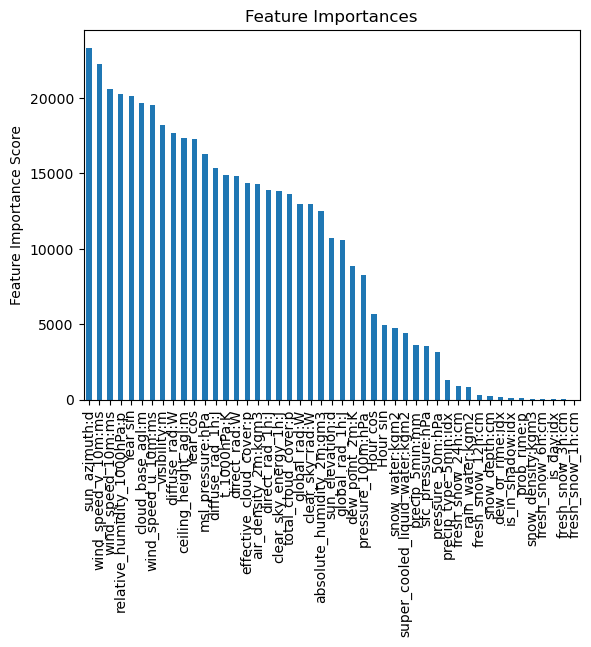

In [47]:
model_a = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=2150,
 max_depth=12,
 min_child_weight=9,
 gamma=0.6165005256630416,
 subsample=0.8252527622974277,
 colsample_bytree=0.8554247446704267,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha=162.96831284007666,
 reg_lambda=.577145045198378,
)

#base: 87.41878562099741 178.89514347259 n=354
#{'colsample_bytree': 0.8554247446704267, 'gamma': 0.6165005256630416, 'max_depth': 12.0, 'min_child_weight': 9.0, 
#'reg_alpha': 162.96831284007666, 'reg_lambda': 7.577145045198378, 'subsample': 0.8252527622974277}

#2.6621074937471367 167.2891383517279
#2.259092664140012 161.6727047272139 n=2150


modelfit(model_a, train_data_a, train_a_y, val_data_a, val_a_y, useTrainCV = False)

In [ ]:
model_b = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=5000,
 max_depth=16,
 min_child_weight=2,
 gamma=3.309632666805953,
 subsample=0.8177536022441664,
 colsample_bytree=0.6767617483945245,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha = 31.870983793041283,
 reg_lambda = 138.25985539261455,
)
#8.933181046173328 31.268779511543418 n= 500

#{'colsample_bytree': 0.6767617483945245, 'gamma': 3.309632666805953, 'max_depth': 16.0, 'min_child_weight': 2.0, 
#'reg_alpha': 31.870983793041283, 'reg_lambda': 138.25985539261455, 'subsample': 0.8177536022441664}

modelfit(model_b, train_data_b, train_b_y, val_data_b, val_b_y, useTrainCV = True)

[16:20:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[16:20:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[16:20:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[16:20:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[16:20:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	train-mae:110.55205+0.25174	test-mae:110.56328+1.03310
[1]	train-mae:105.81940+0.22434	test-mae:105.85490+1.03524
[2]	train-mae:101.28246+0.18869	test-mae:101.34112+1.03419
[3]	train-mae:97.00378+0.19036	test-mae:97.08458+1.00305
[4]	train-mae:92.94951+0.16898	test-mae:93.04134+0.98496
[5]	train

[129]	train-mae:21.19619+0.17427	test-mae:30.02245+0.76810
[130]	train-mae:21.12357+0.17275	test-mae:30.00709+0.76533
[131]	train-mae:21.04761+0.17658	test-mae:29.98263+0.76635
[132]	train-mae:20.97702+0.17481	test-mae:29.96721+0.76998
[133]	train-mae:20.89907+0.17380	test-mae:29.94629+0.77243
[134]	train-mae:20.82761+0.17688	test-mae:29.93183+0.76951
[135]	train-mae:20.75705+0.17087	test-mae:29.91618+0.77012
[136]	train-mae:20.68354+0.17369	test-mae:29.89734+0.77100
[137]	train-mae:20.62043+0.17353	test-mae:29.88532+0.77304
[138]	train-mae:20.54972+0.17325	test-mae:29.87192+0.77773
[139]	train-mae:20.48060+0.17876	test-mae:29.85882+0.78074
[140]	train-mae:20.40902+0.17724	test-mae:29.84240+0.78325
[141]	train-mae:20.34402+0.17358	test-mae:29.82883+0.78432
[142]	train-mae:20.27445+0.17361	test-mae:29.81391+0.78533
[143]	train-mae:20.20645+0.17198	test-mae:29.79912+0.79090
[144]	train-mae:20.14170+0.17259	test-mae:29.79107+0.79153
[145]	train-mae:20.07368+0.17548	test-mae:29.77668+0.795

[268]	train-mae:13.96446+0.20112	test-mae:28.63795+0.89096
[269]	train-mae:13.92886+0.20303	test-mae:28.63444+0.89235
[270]	train-mae:13.89342+0.20305	test-mae:28.62888+0.89148
[271]	train-mae:13.85146+0.20428	test-mae:28.61871+0.89001
[272]	train-mae:13.81301+0.20439	test-mae:28.61084+0.89168
[273]	train-mae:13.77648+0.19894	test-mae:28.60574+0.89222
[274]	train-mae:13.74383+0.19666	test-mae:28.60024+0.89236
[275]	train-mae:13.71108+0.19350	test-mae:28.59954+0.89127
[276]	train-mae:13.67711+0.19642	test-mae:28.59280+0.89068
[277]	train-mae:13.64080+0.19823	test-mae:28.58753+0.89122
[278]	train-mae:13.60497+0.20174	test-mae:28.58230+0.88948
[279]	train-mae:13.56996+0.20169	test-mae:28.57601+0.88841
[280]	train-mae:13.53767+0.19706	test-mae:28.57599+0.88837
[281]	train-mae:13.50413+0.19994	test-mae:28.56967+0.88989
[282]	train-mae:13.46571+0.19649	test-mae:28.56224+0.89438
[283]	train-mae:13.43038+0.19604	test-mae:28.55864+0.89447
[284]	train-mae:13.40110+0.19391	test-mae:28.55849+0.895

[407]	train-mae:9.99905+0.15827	test-mae:28.15143+0.96826
[408]	train-mae:9.97910+0.16000	test-mae:28.14971+0.96709
[409]	train-mae:9.95508+0.15548	test-mae:28.14790+0.96841
[410]	train-mae:9.93471+0.15243	test-mae:28.14758+0.97028
[411]	train-mae:9.91067+0.15109	test-mae:28.14347+0.96875
[412]	train-mae:9.88956+0.15189	test-mae:28.14238+0.96674
[413]	train-mae:9.86962+0.14920	test-mae:28.14120+0.96617
[414]	train-mae:9.84528+0.14846	test-mae:28.13610+0.96847
[415]	train-mae:9.82239+0.14934	test-mae:28.13278+0.96729
[416]	train-mae:9.79689+0.14861	test-mae:28.12844+0.96535
[417]	train-mae:9.77382+0.14793	test-mae:28.12635+0.96524
[418]	train-mae:9.75305+0.14705	test-mae:28.12382+0.96684
[419]	train-mae:9.73038+0.14611	test-mae:28.12028+0.96871
[420]	train-mae:9.70980+0.14545	test-mae:28.11828+0.96656
[421]	train-mae:9.68837+0.14832	test-mae:28.11717+0.96743
[422]	train-mae:9.66932+0.14486	test-mae:28.11631+0.97062
[423]	train-mae:9.64716+0.14481	test-mae:28.11712+0.97139
[424]	train-ma

[549]	train-mae:7.40633+0.13457	test-mae:27.87232+0.99631
[550]	train-mae:7.39096+0.13284	test-mae:27.87075+0.99815
[551]	train-mae:7.37691+0.12963	test-mae:27.86976+0.99876
[552]	train-mae:7.36192+0.13250	test-mae:27.86771+1.00146
[553]	train-mae:7.34946+0.13288	test-mae:27.86735+1.00167
[554]	train-mae:7.33633+0.13316	test-mae:27.86823+1.00299
[555]	train-mae:7.31988+0.13458	test-mae:27.86546+1.00230
[556]	train-mae:7.30261+0.13341	test-mae:27.86206+1.00454
[557]	train-mae:7.28823+0.13569	test-mae:27.86100+1.00484
[558]	train-mae:7.27435+0.13391	test-mae:27.85989+1.00524
[559]	train-mae:7.26018+0.13671	test-mae:27.85708+1.00531
[560]	train-mae:7.24483+0.13647	test-mae:27.85332+1.00388
[561]	train-mae:7.23182+0.13577	test-mae:27.85054+1.00563
[562]	train-mae:7.21847+0.13873	test-mae:27.84909+1.00660
[563]	train-mae:7.20404+0.13912	test-mae:27.84717+1.00695
[564]	train-mae:7.19030+0.13738	test-mae:27.84694+1.00846
[565]	train-mae:7.17394+0.13789	test-mae:27.84279+1.00596
[566]	train-ma

[691]	train-mae:5.57141+0.11160	test-mae:27.64069+1.00525
[692]	train-mae:5.56294+0.11313	test-mae:27.64012+1.00585
[693]	train-mae:5.55333+0.11262	test-mae:27.63879+1.00522
[694]	train-mae:5.54214+0.11452	test-mae:27.63777+1.00570
[695]	train-mae:5.53062+0.11476	test-mae:27.63520+1.00485
[696]	train-mae:5.52045+0.11532	test-mae:27.63462+1.00511
[697]	train-mae:5.50865+0.11630	test-mae:27.63255+1.00510
[698]	train-mae:5.49696+0.11658	test-mae:27.62999+1.00538
[699]	train-mae:5.48709+0.11751	test-mae:27.62819+1.00424
[700]	train-mae:5.47717+0.11855	test-mae:27.62818+1.00332
[701]	train-mae:5.46719+0.11974	test-mae:27.62728+1.00311
[702]	train-mae:5.45648+0.11960	test-mae:27.62571+1.00356
[703]	train-mae:5.44642+0.11872	test-mae:27.62463+1.00280
[704]	train-mae:5.43550+0.11867	test-mae:27.62156+1.00272
[705]	train-mae:5.42422+0.11772	test-mae:27.61868+1.00378
[706]	train-mae:5.41305+0.11872	test-mae:27.61664+1.00437
[707]	train-mae:5.40371+0.11733	test-mae:27.61594+1.00581
[708]	train-ma

[833]	train-mae:4.29669+0.11244	test-mae:27.49045+1.02260
[834]	train-mae:4.28947+0.11354	test-mae:27.48923+1.02310
[835]	train-mae:4.28179+0.11368	test-mae:27.48799+1.02323
[836]	train-mae:4.27424+0.11216	test-mae:27.48731+1.02265
[837]	train-mae:4.26614+0.11113	test-mae:27.48610+1.02344
[838]	train-mae:4.25710+0.11081	test-mae:27.48483+1.02343
[839]	train-mae:4.25030+0.11073	test-mae:27.48395+1.02377
[840]	train-mae:4.24377+0.11011	test-mae:27.48272+1.02415
[841]	train-mae:4.23639+0.11108	test-mae:27.48192+1.02416
[842]	train-mae:4.22820+0.11087	test-mae:27.48081+1.02430
[843]	train-mae:4.22156+0.11108	test-mae:27.47988+1.02352
[844]	train-mae:4.21423+0.11121	test-mae:27.47825+1.02297
[845]	train-mae:4.20615+0.11052	test-mae:27.47693+1.02270
[846]	train-mae:4.19939+0.10959	test-mae:27.47716+1.02284
[847]	train-mae:4.19310+0.10995	test-mae:27.47581+1.02322
[848]	train-mae:4.18503+0.11027	test-mae:27.47490+1.02320
[849]	train-mae:4.17895+0.11048	test-mae:27.47321+1.02463
[850]	train-ma

[975]	train-mae:3.38033+0.09816	test-mae:27.37888+1.02843
[976]	train-mae:3.37577+0.09760	test-mae:27.37833+1.02827
[977]	train-mae:3.37132+0.09826	test-mae:27.37933+1.02807
[978]	train-mae:3.36649+0.09678	test-mae:27.37800+1.02811
[979]	train-mae:3.36067+0.09619	test-mae:27.37691+1.02877
[980]	train-mae:3.35512+0.09596	test-mae:27.37601+1.02899
[981]	train-mae:3.34968+0.09527	test-mae:27.37472+1.02915
[982]	train-mae:3.34381+0.09556	test-mae:27.37395+1.02887
[983]	train-mae:3.33853+0.09530	test-mae:27.37283+1.02967
[984]	train-mae:3.33294+0.09466	test-mae:27.37221+1.03048
[985]	train-mae:3.32762+0.09418	test-mae:27.37120+1.03081
[986]	train-mae:3.32213+0.09396	test-mae:27.37066+1.03127
[987]	train-mae:3.31698+0.09421	test-mae:27.36982+1.03112
[988]	train-mae:3.31189+0.09524	test-mae:27.36927+1.03106
[989]	train-mae:3.30677+0.09529	test-mae:27.36855+1.03093
[990]	train-mae:3.30164+0.09598	test-mae:27.36795+1.03078
[991]	train-mae:3.29635+0.09545	test-mae:27.36735+1.03099
[992]	train-ma

[1115]	train-mae:2.72375+0.07939	test-mae:27.29373+1.03739
[1116]	train-mae:2.72019+0.08005	test-mae:27.29330+1.03718
[1117]	train-mae:2.71604+0.08018	test-mae:27.29304+1.03753
[1118]	train-mae:2.71198+0.08000	test-mae:27.29233+1.03746
[1119]	train-mae:2.70826+0.07938	test-mae:27.29152+1.03706
[1120]	train-mae:2.70430+0.07925	test-mae:27.29120+1.03708
[1121]	train-mae:2.70042+0.07949	test-mae:27.29040+1.03752
[1122]	train-mae:2.69599+0.07861	test-mae:27.28994+1.03785
[1123]	train-mae:2.69225+0.07863	test-mae:27.28924+1.03752
[1124]	train-mae:2.68804+0.07864	test-mae:27.28854+1.03781
[1125]	train-mae:2.68378+0.07845	test-mae:27.28779+1.03795
[1126]	train-mae:2.67942+0.07826	test-mae:27.28728+1.03760
[1127]	train-mae:2.67591+0.07794	test-mae:27.28662+1.03729
[1128]	train-mae:2.67169+0.07801	test-mae:27.28638+1.03679
[1129]	train-mae:2.66816+0.07804	test-mae:27.28619+1.03683
[1130]	train-mae:2.66412+0.07804	test-mae:27.28610+1.03731
[1131]	train-mae:2.65967+0.07770	test-mae:27.28543+1.037

[1254]	train-mae:2.23984+0.06557	test-mae:27.23050+1.03663
[1255]	train-mae:2.23696+0.06587	test-mae:27.23026+1.03689
[1256]	train-mae:2.23368+0.06557	test-mae:27.22961+1.03669
[1257]	train-mae:2.23079+0.06573	test-mae:27.22911+1.03637
[1258]	train-mae:2.22749+0.06556	test-mae:27.22886+1.03671
[1259]	train-mae:2.22461+0.06561	test-mae:27.22827+1.03647
[1260]	train-mae:2.22153+0.06533	test-mae:27.22791+1.03655
[1261]	train-mae:2.21870+0.06492	test-mae:27.22753+1.03664
[1262]	train-mae:2.21557+0.06456	test-mae:27.22697+1.03707
[1263]	train-mae:2.21299+0.06432	test-mae:27.22716+1.03721
[1264]	train-mae:2.21005+0.06454	test-mae:27.22703+1.03747
[1265]	train-mae:2.20686+0.06443	test-mae:27.22685+1.03778
[1266]	train-mae:2.20407+0.06416	test-mae:27.22632+1.03747
[1267]	train-mae:2.20124+0.06407	test-mae:27.22575+1.03756
[1268]	train-mae:2.19824+0.06383	test-mae:27.22518+1.03745
[1269]	train-mae:2.19559+0.06371	test-mae:27.22493+1.03718
[1270]	train-mae:2.19275+0.06388	test-mae:27.22474+1.036

[1393]	train-mae:1.87736+0.05401	test-mae:27.18622+1.03376
[1394]	train-mae:1.87504+0.05390	test-mae:27.18562+1.03361
[1395]	train-mae:1.87272+0.05390	test-mae:27.18556+1.03387
[1396]	train-mae:1.87062+0.05407	test-mae:27.18557+1.03396
[1397]	train-mae:1.86826+0.05423	test-mae:27.18551+1.03390
[1398]	train-mae:1.86614+0.05426	test-mae:27.18527+1.03406
[1399]	train-mae:1.86363+0.05414	test-mae:27.18458+1.03405
[1400]	train-mae:1.86144+0.05428	test-mae:27.18382+1.03385
[1401]	train-mae:1.85903+0.05419	test-mae:27.18358+1.03385
[1402]	train-mae:1.85703+0.05431	test-mae:27.18351+1.03364
[1403]	train-mae:1.85504+0.05424	test-mae:27.18349+1.03381
[1404]	train-mae:1.85275+0.05388	test-mae:27.18303+1.03368
[1405]	train-mae:1.85046+0.05361	test-mae:27.18275+1.03368
[1406]	train-mae:1.84792+0.05363	test-mae:27.18255+1.03366
[1407]	train-mae:1.84571+0.05338	test-mae:27.18178+1.03365
[1408]	train-mae:1.84364+0.05321	test-mae:27.18160+1.03361
[1409]	train-mae:1.84140+0.05318	test-mae:27.18118+1.033

[1532]	train-mae:1.60430+0.04371	test-mae:27.14952+1.03347
[1533]	train-mae:1.60243+0.04374	test-mae:27.14938+1.03321
[1534]	train-mae:1.60077+0.04356	test-mae:27.14897+1.03335
[1535]	train-mae:1.59889+0.04355	test-mae:27.14871+1.03333
[1536]	train-mae:1.59717+0.04341	test-mae:27.14862+1.03313
[1537]	train-mae:1.59550+0.04339	test-mae:27.14827+1.03311
[1538]	train-mae:1.59399+0.04313	test-mae:27.14817+1.03323
[1539]	train-mae:1.59263+0.04319	test-mae:27.14794+1.03329
[1540]	train-mae:1.59086+0.04307	test-mae:27.14774+1.03342
[1541]	train-mae:1.58934+0.04324	test-mae:27.14763+1.03324
[1542]	train-mae:1.58758+0.04306	test-mae:27.14708+1.03327
[1543]	train-mae:1.58589+0.04288	test-mae:27.14726+1.03304
[1544]	train-mae:1.58421+0.04289	test-mae:27.14717+1.03308
[1545]	train-mae:1.58262+0.04299	test-mae:27.14719+1.03307
[1546]	train-mae:1.58108+0.04298	test-mae:27.14704+1.03287
[1547]	train-mae:1.57947+0.04275	test-mae:27.14677+1.03320
[1548]	train-mae:1.57772+0.04260	test-mae:27.14670+1.033

[1671]	train-mae:1.39604+0.03583	test-mae:27.12276+1.03119


[15:08:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-mae:84.13248	validation_1-mae:46.33776
[1]	validation_0-mae:70.39376	validation_1-mae:39.06546
[2]	validation_0-mae:59.64231	validation_1-mae:34.27841
[3]	validation_0-mae:51.13326	validation_1-mae:30.92875
[4]	validation_0-mae:44.89368	validation_1-mae:28.19882
[5]	validation_0-mae:40.23359	validation_1-mae:26.22475
[6]	validation_0-mae:36.67809	validation_1-mae:24.95098
[7]	validation_0-mae:33.93162	validation_1-mae:24.02349
[8]	validation_0-mae:31.79979	validation_1-mae:23.32496
[9]	validation_0-mae:30.06186	validation_1-mae:22.75711
[10]	validation_0-mae:28.74013	validation_1-mae:22.21861
[11]	validation_0-mae:27.63212	validation_1-mae:21.93954
[12]	validation_0-mae:26.70487	validation_1-mae:21.73609
[13]	validation_0-mae:25.84807	validation_1-mae:21.52743
[14]	validation_0-mae:25.20229	validation_1-mae:21.40940
[15]	validation

[142]	validation_0-mae:8.69204	validation_1-mae:22.41149
[143]	validation_0-mae:8.62447	validation_1-mae:22.41628
[144]	validation_0-mae:8.55901	validation_1-mae:22.41645
[145]	validation_0-mae:8.50327	validation_1-mae:22.41672
[146]	validation_0-mae:8.45617	validation_1-mae:22.42082
[147]	validation_0-mae:8.40301	validation_1-mae:22.42544
[148]	validation_0-mae:8.34045	validation_1-mae:22.43093
[149]	validation_0-mae:8.29164	validation_1-mae:22.43408
[150]	validation_0-mae:8.23968	validation_1-mae:22.44943
[151]	validation_0-mae:8.19754	validation_1-mae:22.46141
[152]	validation_0-mae:8.15372	validation_1-mae:22.47590
[153]	validation_0-mae:8.10580	validation_1-mae:22.47458
[154]	validation_0-mae:8.06516	validation_1-mae:22.47084
[155]	validation_0-mae:8.01476	validation_1-mae:22.47004
[156]	validation_0-mae:7.98652	validation_1-mae:22.48482
[157]	validation_0-mae:7.94457	validation_1-mae:22.50388
[158]	validation_0-mae:7.90148	validation_1-mae:22.49778
[159]	validation_0-mae:7.86049	

[286]	validation_0-mae:4.12047	validation_1-mae:22.62658
[287]	validation_0-mae:4.10807	validation_1-mae:22.62135
[288]	validation_0-mae:4.08668	validation_1-mae:22.62442
[289]	validation_0-mae:4.06920	validation_1-mae:22.61564
[290]	validation_0-mae:4.04981	validation_1-mae:22.61535
[291]	validation_0-mae:4.02925	validation_1-mae:22.61293
[292]	validation_0-mae:4.01079	validation_1-mae:22.61678
[293]	validation_0-mae:3.99205	validation_1-mae:22.61871
[294]	validation_0-mae:3.97338	validation_1-mae:22.62123
[295]	validation_0-mae:3.96069	validation_1-mae:22.61713
[296]	validation_0-mae:3.93903	validation_1-mae:22.61481
[297]	validation_0-mae:3.92377	validation_1-mae:22.61056
[298]	validation_0-mae:3.90772	validation_1-mae:22.61192
[299]	validation_0-mae:3.88434	validation_1-mae:22.60675
[300]	validation_0-mae:3.87187	validation_1-mae:22.60971
[301]	validation_0-mae:3.85264	validation_1-mae:22.61456
[302]	validation_0-mae:3.83662	validation_1-mae:22.61776
[303]	validation_0-mae:3.81865	

[430]	validation_0-mae:2.40428	validation_1-mae:22.68825
[431]	validation_0-mae:2.39716	validation_1-mae:22.68734
[432]	validation_0-mae:2.39016	validation_1-mae:22.68875
[433]	validation_0-mae:2.38501	validation_1-mae:22.68893
[434]	validation_0-mae:2.37866	validation_1-mae:22.68883
[435]	validation_0-mae:2.37239	validation_1-mae:22.69079
[436]	validation_0-mae:2.36415	validation_1-mae:22.69038
[437]	validation_0-mae:2.35619	validation_1-mae:22.69143
[438]	validation_0-mae:2.34949	validation_1-mae:22.69172
[439]	validation_0-mae:2.34368	validation_1-mae:22.69402
[440]	validation_0-mae:2.33707	validation_1-mae:22.69608
[441]	validation_0-mae:2.32886	validation_1-mae:22.69867
[442]	validation_0-mae:2.32291	validation_1-mae:22.69657
[443]	validation_0-mae:2.31679	validation_1-mae:22.70018
[444]	validation_0-mae:2.30932	validation_1-mae:22.70075
[445]	validation_0-mae:2.30280	validation_1-mae:22.70153
[446]	validation_0-mae:2.29550	validation_1-mae:22.69696
[447]	validation_0-mae:2.28823	

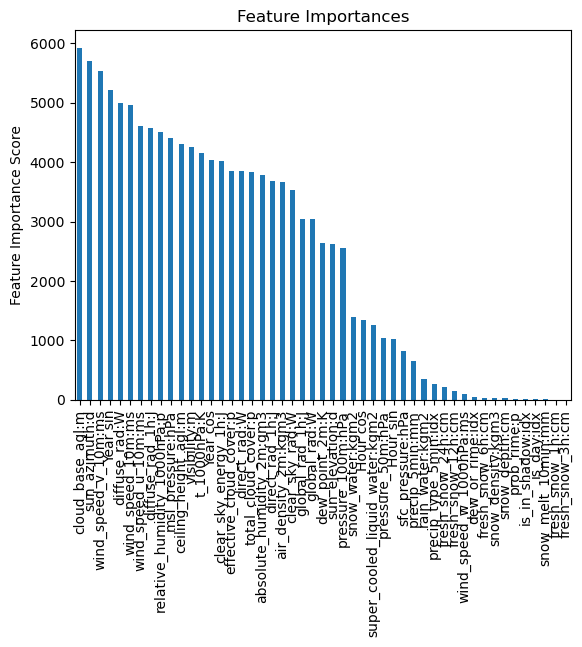

In [35]:
model_c = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=500,
 max_depth=12,
 min_child_weight=4,
 gamma=2.812853936268719,
 subsample=0.7770157483192917,
 colsample_bytree=0.6850141821179164,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha = 88.8755360759813,
 reg_lambda = 135.97616460787322,
)
#9.815685904925928 25.349970592005164 n =292

#{'colsample_bytree': 0.6850141821179164, 'gamma': 2.812853936268719, 'max_depth': 12.0, 'min_child_weight': 4.0, 
#'reg_alpha': 88.8755360759813, 'reg_lambda': 135.97616460787322, 'subsample': 0.7770157483192917}

#1.9761186293029618 22.71585057353815 500

modelfit(model_c, train_data_c, train_c_y, val_data_c, val_c_y, useTrainCV = False)

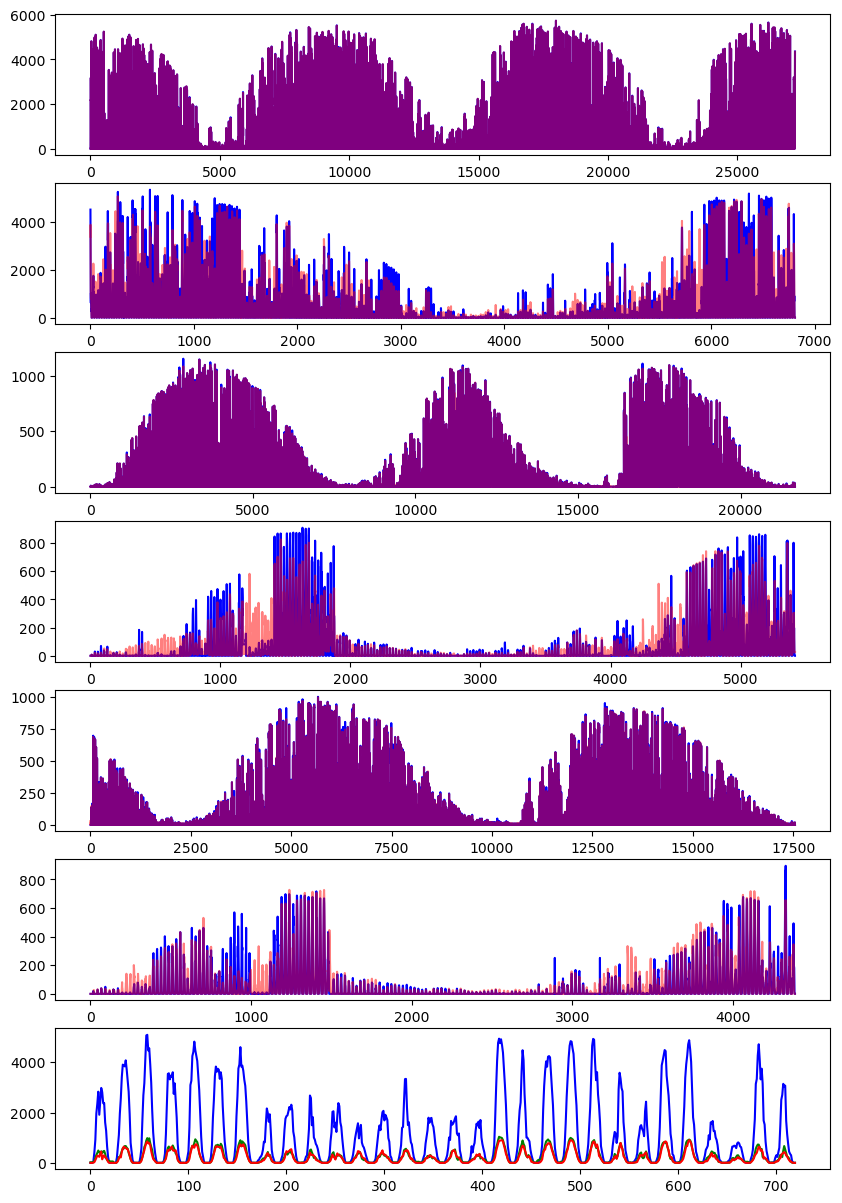

In [48]:
preds_a_train = np.absolute(model_a.predict(train_data_a))
preds_a_val = np.absolute(model_a.predict(val_data_a))
preds_a_test = np.absolute(model_a.predict(test_a))

preds_b_train = np.absolute(model_b.predict(train_data_b))
preds_b_val = np.absolute(model_b.predict(val_data_b))
preds_b_test = np.absolute(model_b.predict(test_b))

preds_c_train = np.absolute(model_c.predict(train_data_c))
preds_c_val = np.absolute(model_c.predict(val_data_c))
preds_c_test = np.absolute(model_c.predict(test_c))

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot((train_a_y), color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.5)

axs[1].plot((val_a_y), color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.5)


axs[2].plot((train_b_y), color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.5)

axs[3].plot((val_b_y), color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.5)

axs[4].plot((train_c_y), color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.5)

axs[5].plot((val_c_y), color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.5)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")


In [43]:
def objective(space):
    
    alg = xgb.XGBRegressor(
     #device='cuda',
     learning_rate =0.2,
     n_estimators= 500,
     max_depth= round(space['max_depth']),
     min_child_weight= space['min_child_weight'],
     gamma=space['gamma'],
     subsample= space['subsample'],
     colsample_bytree= space['colsample_bytree'],
     nthread=4,
     seed=42,
     eval_metric= 'mae',
     booster='gbtree',
     reg_lambda=space['reg_lambda'],
     reg_alpha=space['reg_alpha'],
     early_stopping_rounds = 10
    )
        
    #Fit the algorithm on the data
    alg.fit(train_data_b, train_b_y, eval_set=[(train_data_b, train_b_y),(val_data_b, val_b_y)], verbose=False)
        
    #Predict training set:
    dval_predictions = alg.predict(val_data_b)
    
    mae_val = mean_absolute_error(dval_predictions, val_b_y)
                    
    return {'loss' : mae_val, 'status' : STATUS_OK}

In [44]:
space={
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,180),
        'reg_lambda' : hp.uniform('reg_lambda', 0,180),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

#{'colsample_bytree': 0.8563576286836063, 'gamma': 2.3530939377340916, 'max_depth': 17.0, 'min_child_weight': 9.0, 'reg_alpha': 5.362099435153887, 'reg_lambda': 64.39374187968356, 'subsample': 0.6745835850987192}

100%|██████████████████████████████████████████████| 100/100 [06:55<00:00,  4.15s/trial, best loss: 23.193364703458663]
The best hyperparameters are :  

{'colsample_bytree': 0.6767617483945245, 'gamma': 3.309632666805953, 'max_depth': 16.0, 'min_child_weight': 2.0, 'reg_alpha': 31.870983793041283, 'reg_lambda': 138.25985539261455, 'subsample': 0.8177536022441664}


In [ ]:



param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)]

}

#a
# {'max_depth': 5, 'min_child_weight': 3},
# -0.29519874673217783)

param_test1b = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [2,3,4]
}

#a
#{'max_depth': 4, 'min_child_weight': 4},
# -0.29345904540244516)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

#a
#{'gamma': 0.2},
# -0.2927810275754654)


param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

#b
# {'colsample_bytree': 0.6, 'subsample': 0.9},
# -0.7662817629521412)

param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}

#b
# {'colsample_bytree': 0.6, 'subsample': 0.9},
# -0.7662817629521412)

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 #'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
#b
#{'reg_lambda': 1},
# -0.7662817629521412)

    
# {'reg_alpha': 1e-05},
# -0.7663032075923608)

param_test7 = {
 'reg_alpha':[1e-05, 0, 0.005],
 #'reg_lambda': [0.5, 1, 10, 50]
}




gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.2,
 n_estimators=142,
 max_depth=5,
 min_child_weight=1,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
), 
 param_grid = param_test1, scoring='neg_mean_absolute_error',n_jobs=4, cv=5, verbose=3)


gsearch1.fit(train_data_a, train_a_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [194]:
train_a_y = train_data_a.pop("pv_measurement")
val_a_y = val_data_a.pop("pv_measurement")

train_b_y = train_data_b.pop("pv_measurement")
val_b_y = val_data_b.pop("pv_measurement")

train_c_y = train_data_c.pop("pv_measurement")
val_c_y = val_data_c.pop("pv_measurement")

In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

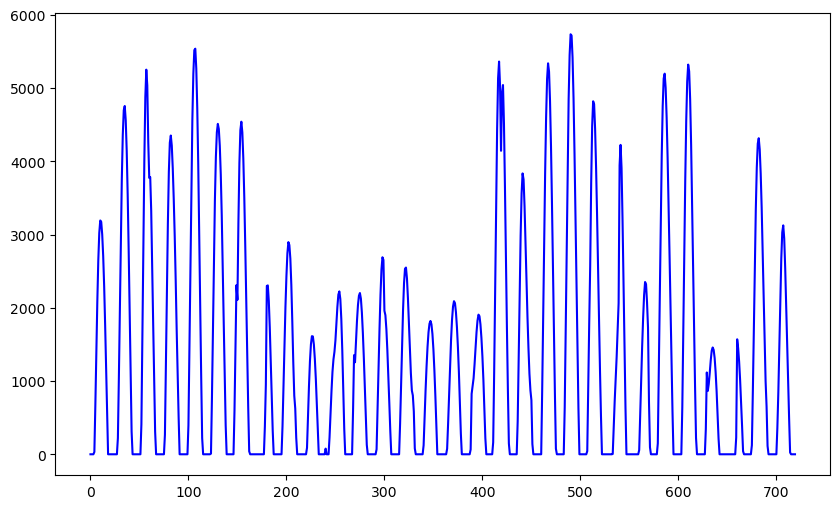

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

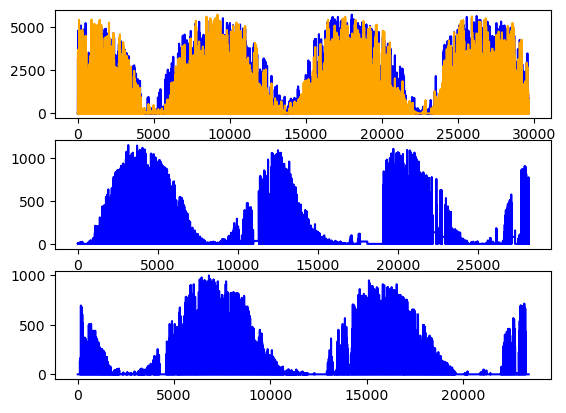

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

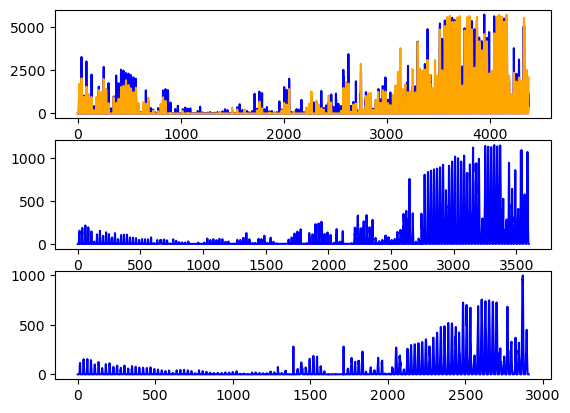

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [59]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [60]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [61]:
submit = np.concatenate((np.concatenate((preds_a_test, preds_b_test)),preds_c_test))

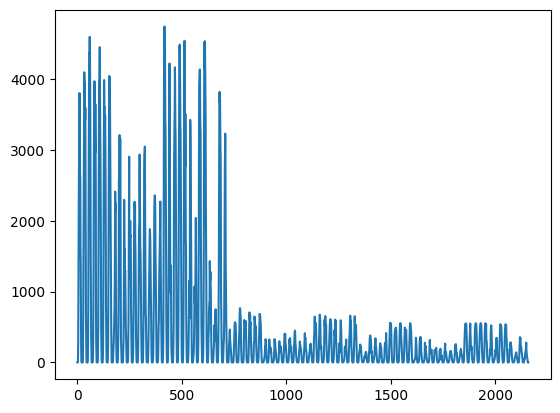

In [62]:
plt.plot(submit)

In [63]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_4.csv", index=False)